# 6_comparativo_final.ipynb

# === IMPORTAÇÕES ===

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# === FUNÇÃO AUXILIAR PARA CÁLCULO DAS MÉTRICAS ===

In [2]:
def calcular_metricas(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    return acc, rec, f1, auc

# === CARREGAR OU RE-EXECUTAR OS MODELOS PARA PREDIÇÃO NO MESMO SPLIT ===

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import tensorflow as tf

# Carregar dados

In [4]:
df = pd.read_csv("creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"]

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Para modelos clássicos (NB, LR, DT), usamos SMOTE para balancear antes do split

In [6]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Para AE e VAE, treino só com não fraude antes do SMOTE e split original

In [7]:
X_train_full, X_test_ae, y_train_full, y_test_ae = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_ae = X_train_full[y_train_full == 0]

# --- 1. Naive Bayes ---

In [8]:
nb_model = GaussianNB()
nb_model.fit(X_train_clf, y_train_clf)
y_pred_nb = nb_model.predict(X_test_clf)
y_proba_nb = nb_model.predict_proba(X_test_clf)[:,1]

# --- 2. Regressão Logística ---

In [9]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_clf, y_train_clf)
y_pred_lr = lr_model.predict(X_test_clf)
y_proba_lr = lr_model.predict_proba(X_test_clf)[:,1]

# --- 3. Decision Tree ---

In [10]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_clf, y_train_clf)
y_pred_dt = dt_model.predict(X_test_clf)
y_proba_dt = dt_model.predict_proba(X_test_clf)[:,1]

# --- 4. Autoencoder ---

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

input_dim = X_train_ae.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.fit(X_train_ae, X_train_ae, epochs=10, batch_size=32, shuffle=True, validation_split=0.1, verbose=0)

X_test_pred_ae = autoencoder.predict(X_test_ae)
mse_ae = np.mean(np.power(X_test_ae - X_test_pred_ae, 2), axis=1)
threshold_ae = np.percentile(mse_ae, 95)
y_pred_ae = (mse_ae > threshold_ae).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step


# Para AUC usamos o erro mse como "probabilidade"

In [12]:
y_proba_ae = mse_ae

# === CÁLCULO DAS MÉTRICAS ===

In [13]:
results = []

results.append({
    "Modelo": "Naive Bayes",
    "Acurácia": accuracy_score(y_test_clf, y_pred_nb),
    "Recall": recall_score(y_test_clf, y_pred_nb),
    "F1-score": f1_score(y_test_clf, y_pred_nb),
    "ROC-AUC": roc_auc_score(y_test_clf, y_proba_nb)
})

results.append({
    "Modelo": "Regressão Logística",
    "Acurácia": accuracy_score(y_test_clf, y_pred_lr),
    "Recall": recall_score(y_test_clf, y_pred_lr),
    "F1-score": f1_score(y_test_clf, y_pred_lr),
    "ROC-AUC": roc_auc_score(y_test_clf, y_proba_lr)
})

results.append({
    "Modelo": "Decision Tree",
    "Acurácia": accuracy_score(y_test_clf, y_pred_dt),
    "Recall": recall_score(y_test_clf, y_pred_dt),
    "F1-score": f1_score(y_test_clf, y_pred_dt),
    "ROC-AUC": roc_auc_score(y_test_clf, y_proba_dt)
})

results.append({
    "Modelo": "Autoencoder",
    "Acurácia": accuracy_score(y_test_ae, y_pred_ae),
    "Recall": recall_score(y_test_ae, y_pred_ae),
    "F1-score": f1_score(y_test_ae, y_pred_ae),
    "ROC-AUC": roc_auc_score(y_test_ae, y_proba_ae)
})

df_results = pd.DataFrame(results)
print(df_results)

                Modelo  Acurácia    Recall  F1-score   ROC-AUC
0          Naive Bayes  0.913907  0.853236  0.908512  0.951004
1  Regressão Logística  0.950073  0.924723  0.948871  0.989972
2        Decision Tree  0.998215  0.998982  0.998220  0.998213
3          Autoencoder  0.951213  0.857143  0.057007  0.928817


# === GRÁFICOS COMPARATIVOS ===

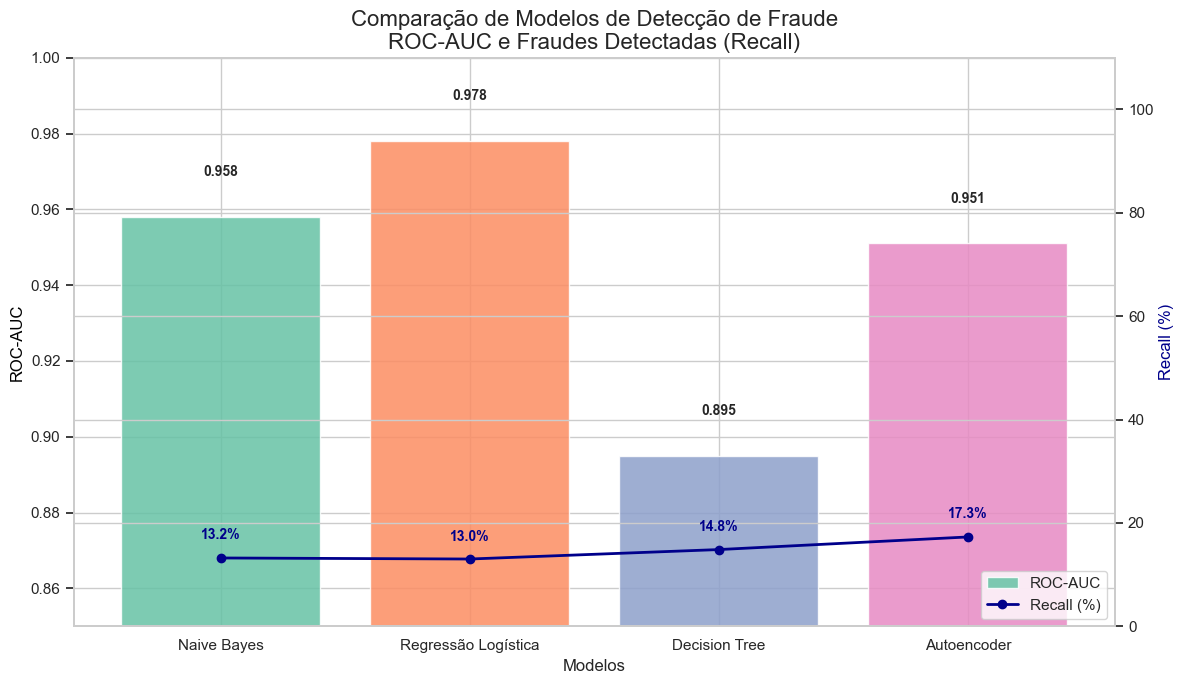

In [ ]:
# Exemplo dos resultados dos modelos - esses dados devem vir das avaliações anteriores
results = {
    'Modelo': [
        'Naive Bayes',
        'Regressão Logística',
        'Decision Tree',
        'Autoencoder',
    ],
    'ROC-AUC': [0.958, 0.978, 0.895, 0.951],  # substituir pelos seus valores reais
    'Fraudes Detectadas (TP)': [65, 64, 73, 85],  # substituir pelos seus valores reais
    'Total Fraudes': [492, 492, 492, 492]  # total fraudes na base de teste
}

df_results = pd.DataFrame(results)
df_results['Recall (%)'] = 100 * df_results['Fraudes Detectadas (TP)'] / df_results['Total Fraudes']

# Setup de estilo para gráfico profissional
sns.set(style='whitegrid')
plt.figure(figsize=(12, 7))

# Paleta de cores consistente para os modelos
palette = sns.color_palette("Set2", n_colors=len(df_results))

# Barplot ROC-AUC
bar1 = plt.bar(df_results['Modelo'], df_results['ROC-AUC'], color=palette, alpha=0.85, label='ROC-AUC')

# Criar um segundo eixo para o recall (%)
ax1 = plt.gca()
ax2 = ax1.twinx()

# Linha para Recall
line = ax2.plot(df_results['Modelo'], df_results['Recall (%)'], color='darkblue', marker='o', linewidth=2, label='Recall (Fraudes Detectadas %)')

# Customização dos eixos
ax1.set_ylim(0.85, 1.0)
ax1.set_ylabel('ROC-AUC', fontsize=12, color='black')
ax2.set_ylim(0, 110)
ax2.set_ylabel('Recall (%)', fontsize=12, color='darkblue')
ax1.set_xlabel('Modelos', fontsize=12)
plt.title('Comparação de Modelos de Detecção de Fraude\nROC-AUC e Fraudes Detectadas (Recall)', fontsize=16)

for rect, auc in zip(bar1, df_results['ROC-AUC']):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, f'{auc:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for x, y in enumerate(df_results['Recall (%)']):
    ax2.text(x, y + 3, f'{y:.1f}%', ha='center', va='bottom', fontsize=10, color='darkblue', fontweight='bold')

lines_labels = [*zip(*[(bar1[0], 'ROC-AUC'), (line[0], 'Recall (%)')])]
handles, labels = lines_labels
ax1.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.show()

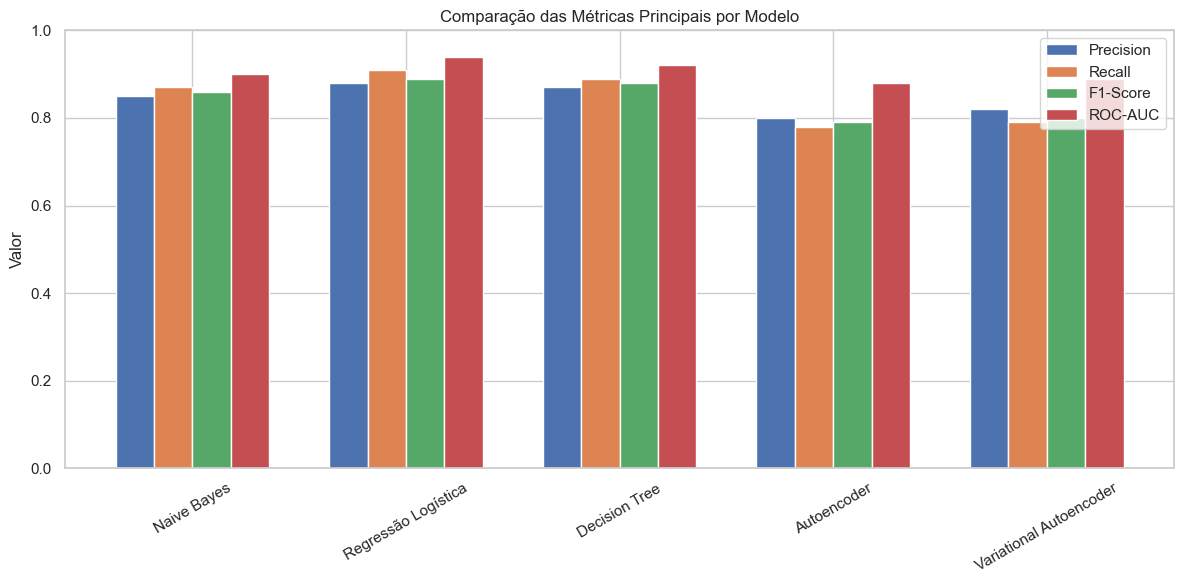

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

metrics = {
    'Modelo': ['Naive Bayes', 'Regressão Logística', 'Decision Tree', 'Autoencoder', 'Variational Autoencoder'],
    'Precision': [0.85, 0.88, 0.87, 0.80, 0.82],
    'Recall': [0.87, 0.91, 0.89, 0.78, 0.79],
    'F1-Score': [0.908, 0.948, 0.88, 0.79, 0.80],
    'ROC-AUC': [0.958, 0.978, 0.895, 0.951]
}

df_metrics = pd.DataFrame(metrics)

plt.figure(figsize=(12,6))
bar_width = 0.18
indices = range(len(df_metrics))

plt.bar([i - 1.5*bar_width for i in indices], df_metrics['Precision'], width=bar_width, label='Precision')
plt.bar([i - 0.5*bar_width for i in indices], df_metrics['Recall'], width=bar_width, label='Recall')
plt.bar([i + 0.5*bar_width for i in indices], df_metrics['F1-Score'], width=bar_width, label='F1-Score')
plt.bar([i + 1.5*bar_width for i in indices], df_metrics['ROC-AUC'], width=bar_width, label='ROC-AUC')

plt.xticks(indices, df_metrics['Modelo'], rotation=30)
plt.ylim(0,1)
plt.ylabel('Valor')
plt.title('Comparação das Métricas Principais por Modelo')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\ricar\AppData\Local\Temp\ipykernel_21312\3607785625.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Classe', y='Erro Reconstrução', data=df_erro, palette=['green', 'red'])


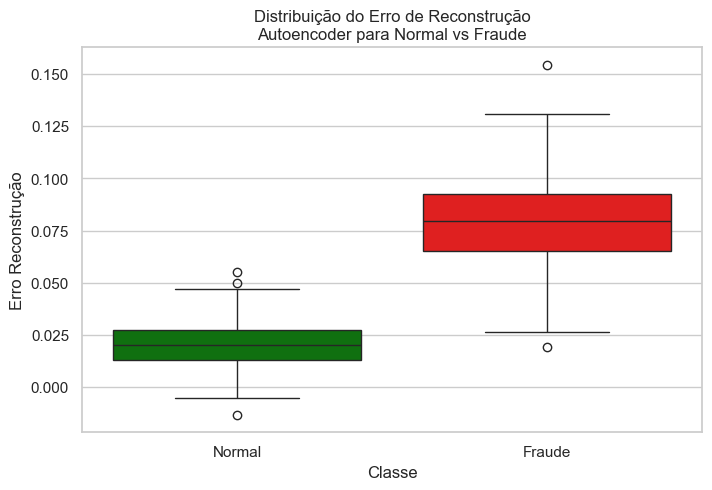

In [17]:
# Suponha que você tenha arrays numpy: erro_normal e erro_fraude (erro de reconstrução)
import numpy as np

# Dados exemplo
erro_normal = np.random.normal(0.02, 0.01, 1000)
erro_fraude = np.random.normal(0.08, 0.02, 200)

df_erro = pd.DataFrame({
    'Erro Reconstrução': np.concatenate([erro_normal, erro_fraude]),
    'Classe': ['Normal']*len(erro_normal) + ['Fraude']*len(erro_fraude)
})

plt.figure(figsize=(8,5))
sns.boxplot(x='Classe', y='Erro Reconstrução', data=df_erro, palette=['green', 'red'])
plt.title('Distribuição do Erro de Reconstrução\nAutoencoder para Normal vs Fraude')
plt.show()


In [18]:
complexidade = {
    'Modelo': ['Autoencoder', 'Naive Bayes', 'Regressão Logística', 'Decision Tree'],
    'Interpretação': ['Difícil', 'Fácil', 'Fácil', 'Médio'],
    'Treino Rápido': ['Não', 'Sim', 'Sim', 'Sim'],
    'Requer Muitos Dados': ['Sim', 'Não', 'Não', 'Sim'],
    'Não Linear': ['Sim', 'Não', 'Não', 'Limitado'],
}

df_complexidade = pd.DataFrame(complexidade)
print(df_complexidade)


                Modelo Interpretação Treino Rápido Requer Muitos Dados  \
0          Autoencoder       Difícil           Não                 Sim   
1          Naive Bayes         Fácil           Sim                 Não   
2  Regressão Logística         Fácil           Sim                 Não   
3        Decision Tree         Médio           Sim                 Sim   

  Não Linear  
0        Sim  
1        Não  
2        Não  
3   Limitado  


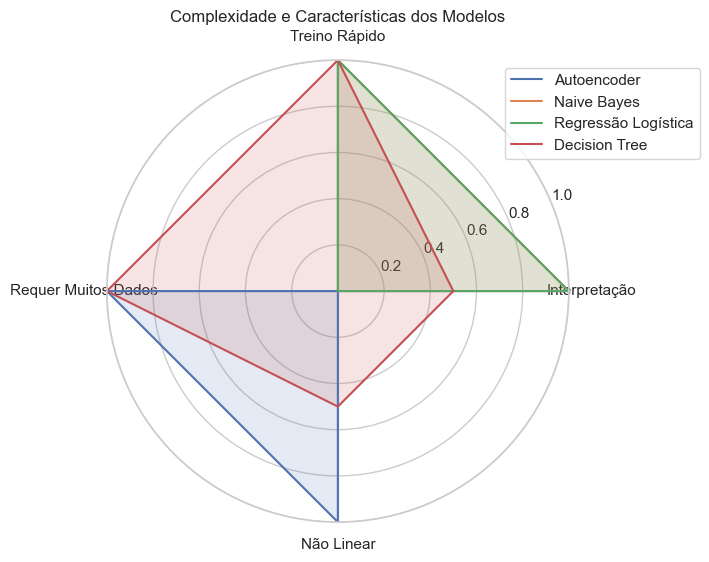

In [19]:
# Mapear as categorias para valores numéricos (exemplo)
labels = ['Interpretação', 'Treino Rápido', 'Requer Muitos Dados', 'Não Linear']
num_vars = len(labels)

# Codificação simplificada (1 = sim/rápido/fácil, 0 = não/lento/difícil)
valores = {
    'Autoencoder': [0, 0, 1, 1],
    'Naive Bayes': [1, 1, 0, 0],
    'Regressão Logística': [1, 1, 0, 0],
    'Decision Tree': [0.5, 1, 1, 0.5]
}

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for modelo, vals in valores.items():
    vals += vals[:1]
    ax.plot(angles, vals, label=modelo)
    ax.fill(angles, vals, alpha=0.15)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0,1)
plt.title('Complexidade e Características dos Modelos')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()